# Realtor.com Data Analysis
This is quick script to visualize some of the key metrics of the housing market that realtor.com compiles and provides for free on their website. Data is at the state and month level. The script should pull in the most up top date data and defaults to using the most recent complete month when reporting on year over year and month over month trends.

Metrics:
* Number of new listings (new supply)
* NUmber of active listings (total supply)
* Number of listings that went into pending 
* Median number of days on market (precursor to price increases/reductions)
* Median list price
* Number of price increases
* Number of price reductions


In [75]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
pd.set_option('display.max_columns', 500)

## Dataset import and prep

In [32]:
realtor_data_raw = pd.read_csv("https://econdata.s3-us-west-2.amazonaws.com/Reports/Core/RDC_Inventory_Core_Metrics_State_History.csv")

# for some reason the final row was corrupt with a note
realtor_data = realtor_data_raw.drop(realtor_data_raw.tail(1).index)

df = (realtor_data
    .drop(labels = ['state'], axis = 1)
    .assign(month_date_yyyymm = (realtor_data['month_date_yyyymm'] + "01").astype('datetime64'))
    .rename(columns = {'month_date_yyyymm':'month','state_id':'state'})
    .astype({'state':'category'})
    .sort_values(by = ['state','month'], ascending = True)
    )

In [33]:
df.columns

Index(['month', 'state', 'median_listing_price', 'median_listing_price_mm',
       'median_listing_price_yy', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market', 'median_days_on_market_mm',
       'median_days_on_market_yy', 'new_listing_count', 'new_listing_count_mm',
       'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy', 'total_listing_count',
       'total_listing_cou

In [34]:
cols = ['month', 'state',
       'median_listing_price',
       #'median_listing_price_mm', 'median_listing_price_yy',
       'active_listing_count', #'active_listing_count_mm',
       #'active_listing_count_yy', 
       'median_days_on_market',
       #'median_days_on_market_mm', 'median_days_on_market_yy',
       'new_listing_count', 
       #'new_listing_count_mm', 'new_listing_count_yy',
       'price_increased_count', 
       #'price_increased_count_mm','price_increased_count_yy', 
       'price_reduced_count',
       #'price_reduced_count_mm', 'price_reduced_count_yy',
       'pending_listing_count', 
       #'pending_listing_count_mm', 'pending_listing_count_yy',
       #'median_listing_price_per_square_foot',
       #'median_listing_price_per_square_foot_mm','median_listing_price_per_square_foot_yy', 
       'median_square_feet',
       #'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 
       #'average_listing_price_mm', 'average_listing_price_yy', 
       # 'total_listing_count',
       #'total_listing_count_mm', 'total_listing_count_yy', 'pending_ratio',
       #'pending_ratio_mm', 'pending_ratio_yy', 'quality_flag'
       ]

df = df[cols]

In [35]:
df = df.rename(columns = {'median_listing_price':'med_lp',
                          'active_listing_count':'active_listings',
                          'median_days_on_market':'med_dom',
                          'new_listing_count':'new_listings',
                          'price_increased_count':'price_increases',
                          'price_reduced_count':'price_reductions',
                          'pending_listing_count':'pending_listings',
                          'median_square_feet':'med_sf',
                          'average_listing_price':'avg_lp'})



In [135]:
# Month number and year columns, useful for time series plots
df = df.assign(
        month_num = lambda x: x.month.dt.month,
        year = lambda x: x.month.dt.year)

def get_pct_change(column, periods):
    return(df.groupby('state')[column].transform(lambda x: x.pct_change(periods = periods)*100))


# percent change year over year
df['pct_ch_med_list_1y'] = get_pct_change('med_lp', periods = 12)
df['pct_ch_active_list_1y'] = get_pct_change('active_listings', periods = 12)
df['pct_ch_med_dom_1y'] = get_pct_change('med_dom', periods = 12)
df['pct_ch_new_list_1y'] = get_pct_change('new_listings', periods = 12)
df['pct_ch_price_inc_1y'] = get_pct_change('price_increases', periods = 12)
df['pct_ch_price_red_1y'] = get_pct_change('price_reductions', periods = 12)
df['pct_ch_pending_1y'] = get_pct_change('pending_listings', periods = 12)

# percent change month over month
df['pct_ch_med_list_1m'] = get_pct_change('med_lp', periods = 1)
df['pct_ch_active_list_1m'] = get_pct_change('active_listings', periods = 1)
df['pct_ch_med_dom_1m'] = get_pct_change('med_dom', periods = 1)
df['pct_ch_new_list_1m'] = get_pct_change('new_listings', periods = 1)
df['pct_ch_price_inc_1m'] = get_pct_change('price_increases', periods = 1)
df['pct_ch_price_red_1m'] = get_pct_change('price_reductions', periods = 1)
df['pct_ch_pending_1m'] = get_pct_change('pending_listings', periods = 1)


df.head()


,month,state,med_lp,active_listings,med_dom,new_listings,price_increases,price_reductions,pending_listings,med_sf,avg_lp,month_num,year,pct_ch_med_list_1m,pct_ch_active_list_1m,pct_ch_med_dom_1m,pct_ch_new_list_1m,pct_ch_price_inc_1m,pct_ch_price_red_1m,pct_ch_pending_1m,pct_ch_med_list_1y,pct_ch_active_list_1y,pct_ch_med_dom_1y,pct_ch_new_list_1y,pct_ch_price_inc_1y,pct_ch_price_red_1y,pct_ch_pending_1y
3841,2016-07-01,AK,289900.0,3745.0,69.0,1268.0,44.0,1188.0,3.0,1800.0,333200.0,7,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3800,2016-08-01,AK,287975.0,3679.0,75.0,1116.0,46.0,1258.0,3.0,1794.0,329918.0,8,2016,-0.664022,-1.762350,8.695652,-11.987382,4.545455,5.892256,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3735,2016-09-01,AK,285000.0,3578.0,80.0,920.0,18.0,1132.0,4.0,1788.0,327484.0,9,2016,-1.033076,-2.745311,6.666667,-17.562724,-60.869565,-10.015898,33.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3682,2016-10-01,AK,280000.0,3251.0,86.0,780.0,24.0,896.0,4.0,1772.0,327819.0,10,2016,-1.754386,-9.139184,7.500000,-15.217391,33.333333,-20.848057,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3653,2016-11-01,AK,279938.0,2935.0,94.0,630.0,12.0,644.0,4.0,1775.0,329431.0,11,2016,-0.022143,-9.720086,9.302326,-19.230769,-50.000000,-28.125000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Summary of Key Metrics

In [143]:
def get_obs(column):
    return(np.round(df.query("month == @analysis_month").loc[:, column].mean(),2))


current_month = datetime.now().month -1
current_year = datetime.now().year

analysis_month = str(current_year)+'-'+str(current_month) + '-'+'01'
analysis_month

'2022-10-01'

#### What is happening with housing supply?

In [147]:
a = get_obs(column = 'pct_ch_active_list_1y')
b = get_obs(column = 'pct_ch_active_list_1m')

c = get_obs(column = 'pct_ch_new_list_1y')
d = get_obs(column = 'pct_ch_new_list_1m')

print("For the month of ", analysis_month, ":")
print(" ")
print("The average number of active listings has changed by", a, "% year over year and by", b, "% month over month")
print("------------------------")
print("The average number of new listings has changed by", c, "% year over year and by", d, "% month over month")

For the month of  2022-10-01 :
 
The average number of active listings has changed by 29.67 % year over year and by 2.59 % month over month
------------------------
The average number of new listings has changed by -14.28 % year over year and by -10.88 % month over month


### Whats happening to the number of houses getting sold? How long are listings staying on market?

In [137]:
a = get_obs(column = 'pct_ch_pending_1y')
b = get_obs(column = 'pct_ch_pending_1m')

c = get_obs(column = 'pct_ch_med_dom_1y')
d = get_obs(column = 'pct_ch_med_dom_1m')

print("For the month of ", analysis_month, ":")
print(" ")
print("The average number of pending listings has changed by", a, "% year over year and by", b, "% month over month")
print("------------------------")
print("The average change for the median days on market across states is", c, "% year over year and by", d, "% month over month")

The average number of pending listings has changed by -30.63 % year over year and by -11.31 % month over month
------------------------
The average change for the median days on market across states is 15.74 % year over year and by 3.93 % month over month


### What is happening to housing prices?

In [158]:
a = get_obs(column = 'pct_ch_med_list_1y')
b = get_obs(column = 'pct_ch_med_list_1m')

c = get_obs(column = 'pct_ch_price_inc_1y')
d = get_obs(column = 'pct_ch_price_inc_1m')

e = get_obs(column = 'pct_ch_price_red_1y')
f =get_obs(column = 'pct_ch_price_red_1m')

print("For the month of ", analysis_month, ":")
print(" ")
print("The average change for the median list price across states is", a, "% year over year and by", b, "% month over month")
print("------------------------")
print("The average number of price increases has changed by", c, "% year over year and by", d, "% month over month")
print("------------------------")
print("The average number of price reductions has changed by", e, "% year over year and by", f, "% month over month")

For the month of  2022-10-01 :
 
The average change for the median list price across states is 14.36 % year over year and by -0.23 % month over month
------------------------
The average number of price increases has changed by -38.69 % year over year and by -7.09 % month over month
------------------------
The average number of price reductions has changed by 78.14 % year over year and by 2.89 % month over month


### Snapshot of year over year results in more detail

In [154]:
(df.query("month ==@analysis_month")
.loc[:,df.columns.str.endswith('1y')]
.describe()
.T)

,count,mean,std,min,25%,50%,75%,max
pct_ch_med_list_1y,51.0,14.356923,7.986179,2.142857,7.946382,13.513514,20.473832,32.307692
pct_ch_active_list_1y,51.0,29.669308,35.306069,-18.336762,3.968457,20.973154,49.346232,136.141762
pct_ch_med_dom_1y,51.0,15.740622,21.547790,-11.111111,4.677830,8.000000,20.204082,103.125000
pct_ch_new_list_1y,51.0,-14.277914,11.018314,-72.030480,-18.878166,-14.626866,-7.558016,3.793322
pct_ch_price_inc_1y,51.0,-38.691701,24.125401,-94.415358,-51.438541,-42.702703,-28.463178,50.000000
pct_ch_price_red_1y,51.0,78.138328,75.079271,-6.260297,24.422132,53.225806,140.468730,346.744412
pct_ch_pending_1y,51.0,-30.631951,8.875753,-43.722084,-36.484080,-31.379749,-26.527349,0.660352


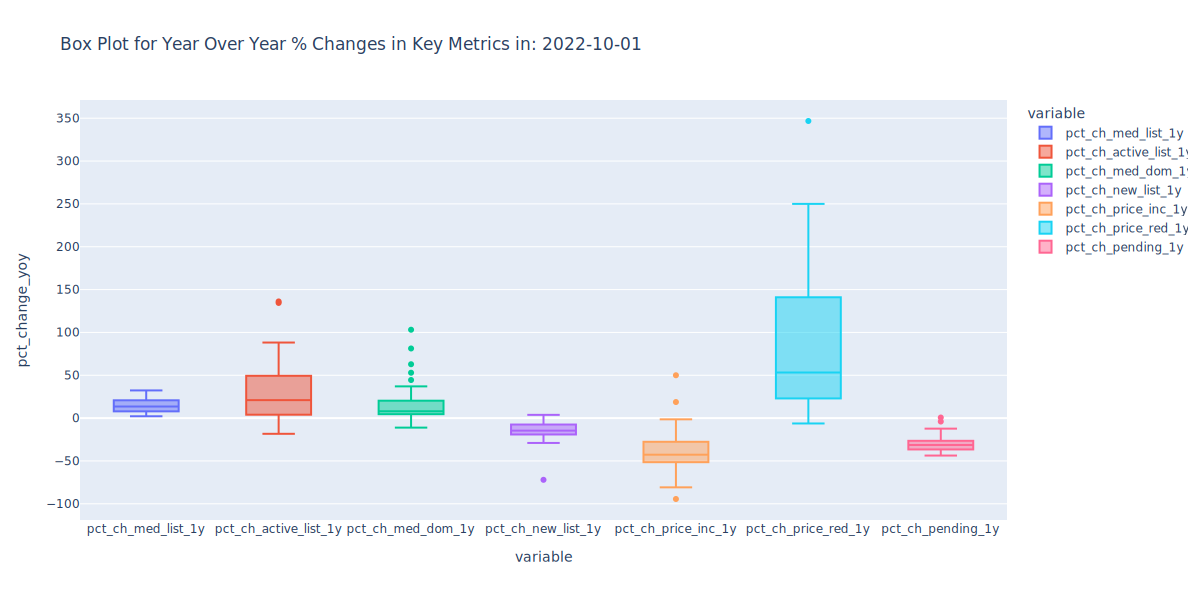

In [149]:
px.box(df.query("month == @analysis_month")
        .loc[:,df.columns.str.endswith('1y')]
        .melt(value_name = 'pct_change_yoy'),
        x= 'variable',
        y = 'pct_change_yoy',
        color = 'variable',
        height= 600,
        width = 1200,
        title = "Box Plot for Year Over Year % Changes in Key Metrics in: " + analysis_month).show(renderer = 'svg')

### Snapshot of month over month results in more detail

In [155]:
(df.query("month == @analysis_month")
.loc[:,df.columns.str.endswith('1m')]
.describe()
.T)

,count,mean,std,min,25%,50%,75%,max
pct_ch_med_list_1m,51.0,-0.234245,1.315871,-3.273138,-1.030315,-0.166667,0.200612,4.078390
pct_ch_active_list_1m,51.0,2.589389,3.607744,-6.565657,0.108041,3.040047,4.940300,10.381143
pct_ch_med_dom_1m,51.0,3.926582,5.828519,-14.285714,0.000000,3.846154,8.333333,15.384615
pct_ch_new_list_1m,51.0,-10.877558,6.753276,-32.280255,-13.512810,-10.738962,-6.079681,0.426257
pct_ch_price_inc_1m,51.0,-7.087997,23.567926,-42.105263,-21.020143,-10.798122,2.763985,100.000000
pct_ch_price_red_1m,51.0,2.893505,8.530958,-18.151815,-1.961172,2.452316,8.908466,22.413793
pct_ch_pending_1m,51.0,-11.311970,3.935092,-17.994100,-14.410921,-11.323851,-9.519395,6.097561


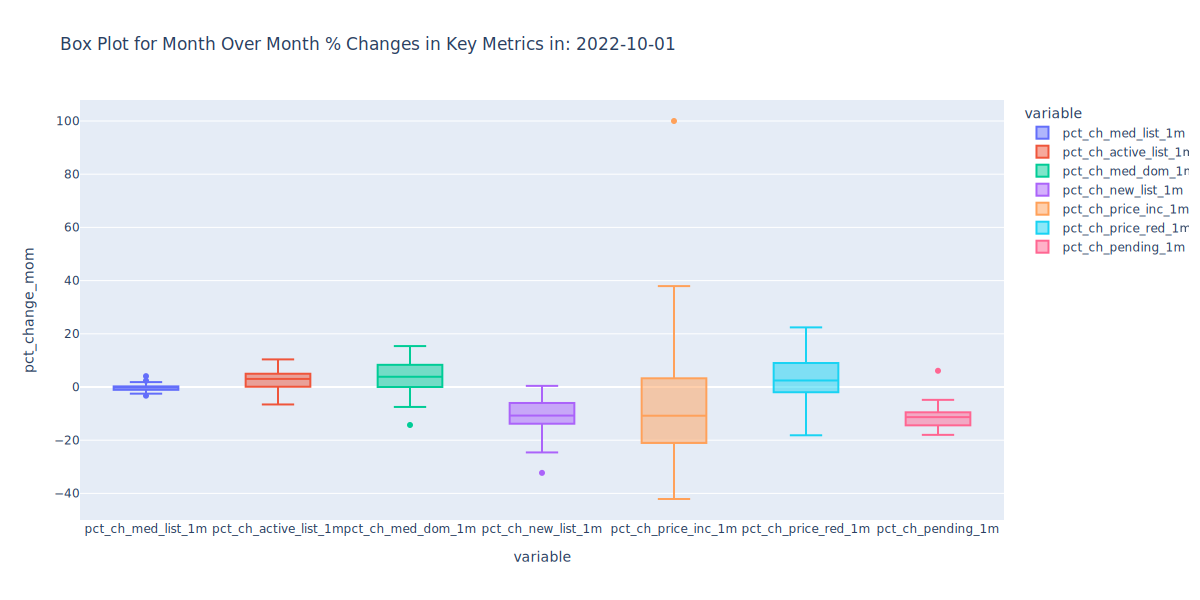

In [156]:
px.box(df.query("month == @analysis_month")
        .loc[:,df.columns.str.endswith('1m')]
        .melt(value_name = 'pct_change_mom'),
        x= 'variable',
        y = 'pct_change_mom',
        color = 'variable',
        height= 600,
        width = 1200,
        title = "Box Plot for Month Over Month % Changes in Key Metrics in: " + analysis_month).show(renderer = 'svg')

## Visualizing key metrics by State

In [39]:
select_states = ['NE','KA','WY','CA','OR','PA','CO','IL','WI','UT','ID','MI','NY']
select_states

['NE', 'KA', 'WY', 'CA', 'OR', 'PA', 'CO', 'IL', 'WI', 'UT', 'ID', 'MI', 'NY']

### Number of active listings ( total supply)

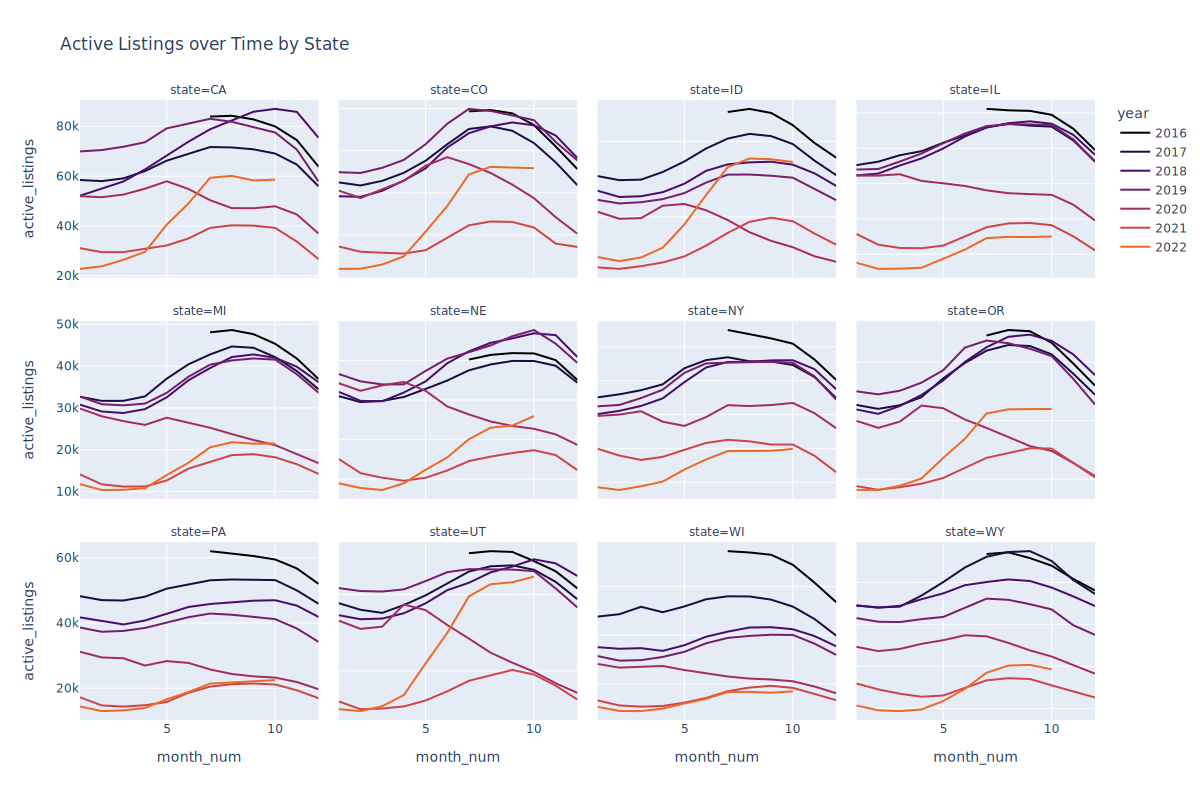

In [46]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'active_listings',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Active Listings over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show(renderer = 'svg')

### Number of listings that had a status of 'pending' during the month 

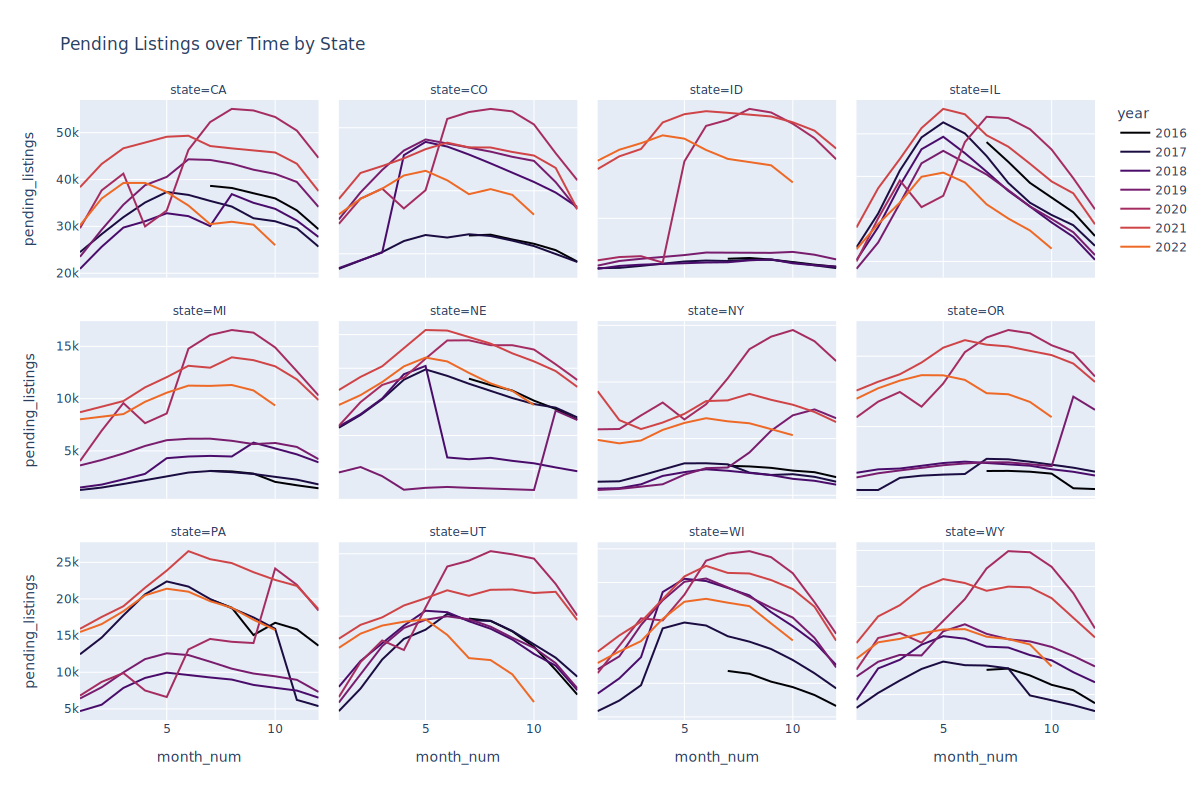

In [41]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'pending_listings',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Pending Listings over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show(renderer = 'svg')

### Median number of days listings remain on the market 

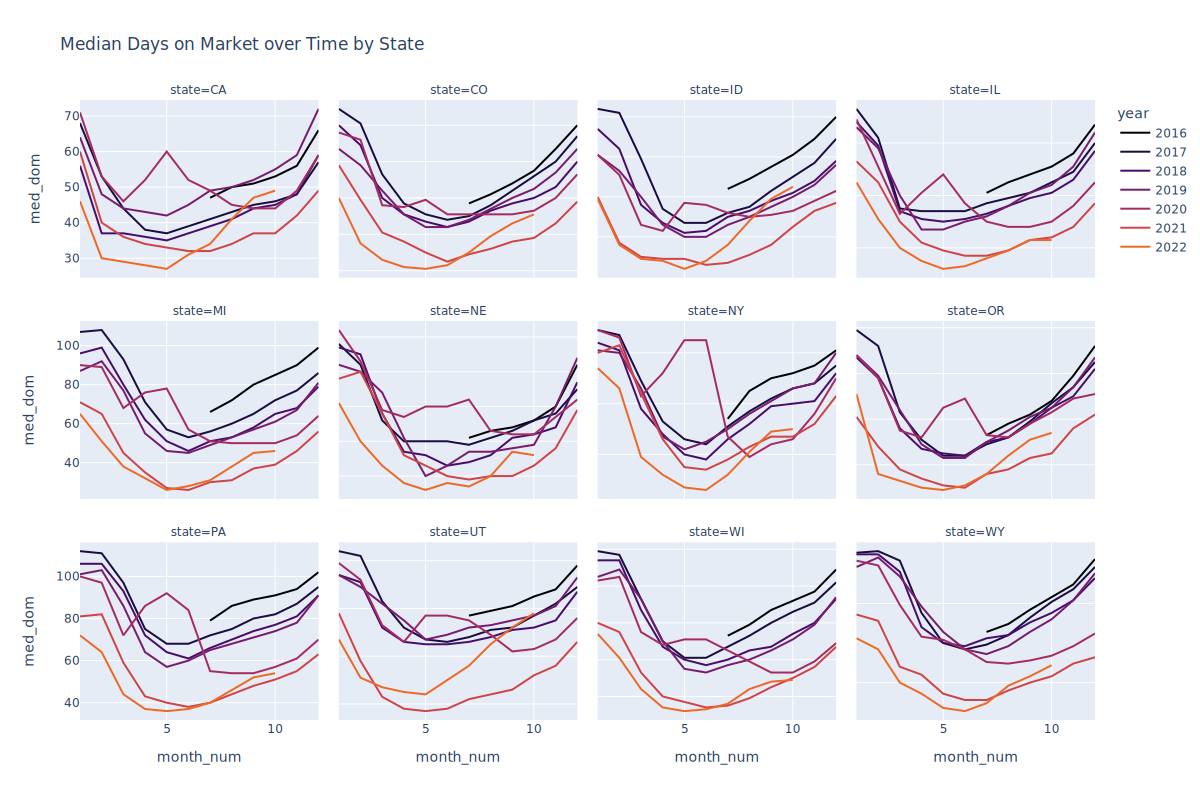

In [42]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'med_dom',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Median Days on Market over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show(renderer = 'svg')

### Median List Prices

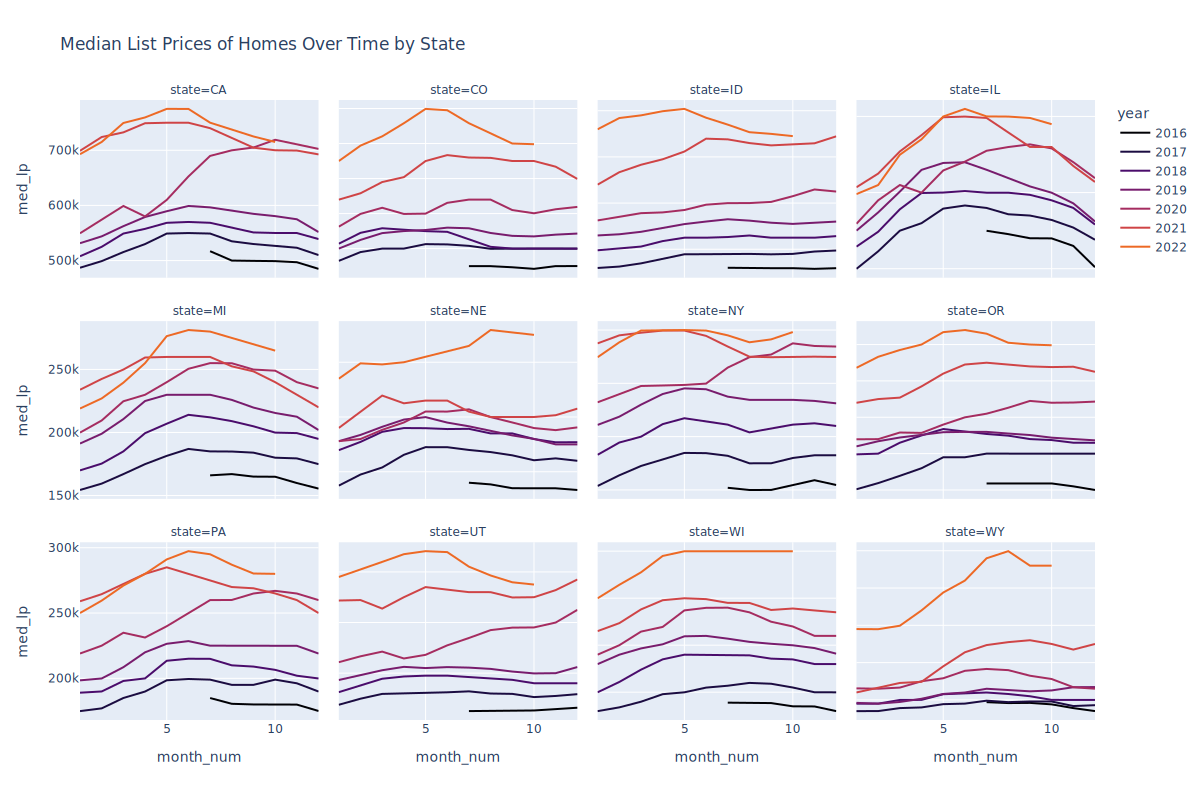

In [43]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'med_lp',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Median List Prices of Homes Over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show(renderer = 'svg')

### Number of listed properties with price reductions 

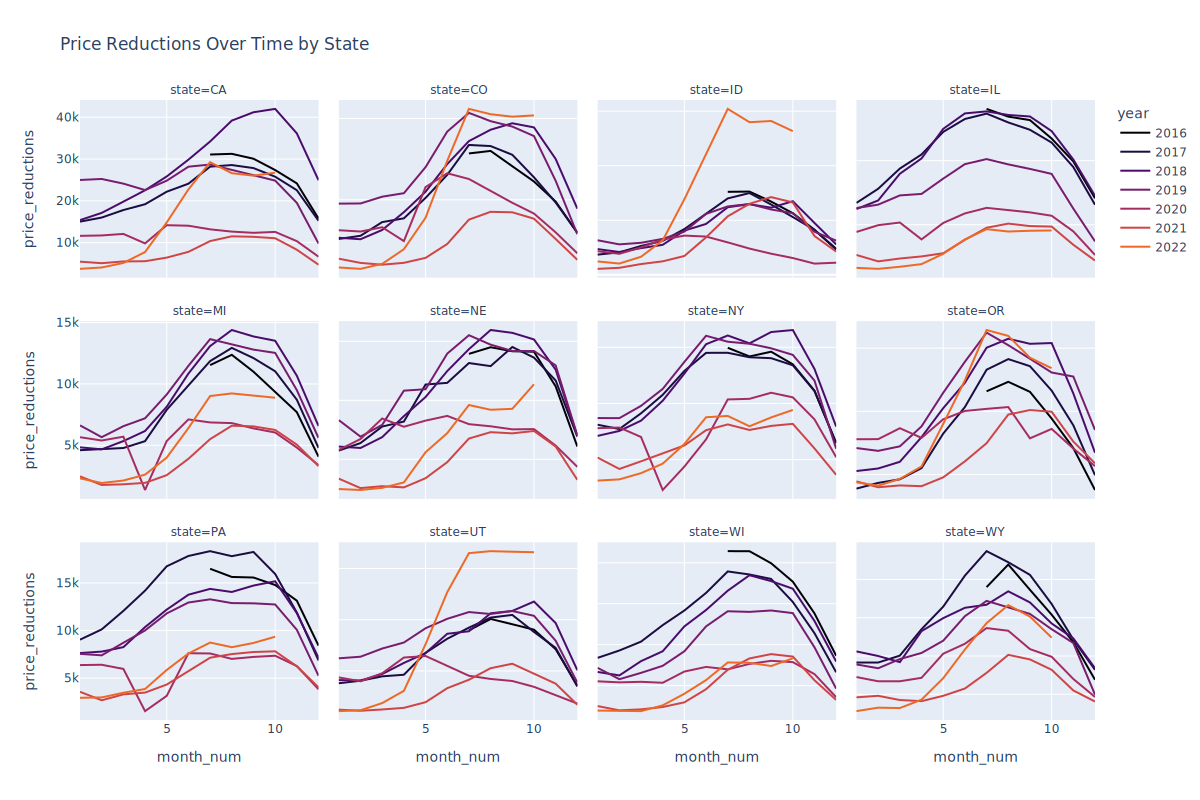

In [87]:
fig = px.line(df.query("state in @select_states"),
    x = 'month_num',
    y = 'price_reductions',
    color = 'year',
    facet_col = 'state',
    facet_col_wrap = 4,
    title = 'Price Reductions Over Time by State',
    color_discrete_sequence=px.colors.sequential.Inferno
    )
fig.update_yaxes(matches = None)
fig.update_layout(height = 800, width = 1200)
fig.show(renderer = 'svg')

### State by state look at key metrics

In [192]:
import plotly.graph_objects as go

def four_key_metric_plot(state):
    st = (df.query("state ==@state")
        .loc[:,('month','month_num','year','active_listings','pending_listings','med_dom','price_reductions')]
        #.melt(id_vars=['month','month_num','year'])
        )
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=st.month,
        y=st.active_listings,
        name="Active Listings"
    ))


    fig.add_trace(go.Scatter(
        x=st.month,
        y=st.pending_listings,
        name="Pending Listings",
        yaxis="y2"
    ))

    fig.add_trace(go.Scatter(
        x=st.month,
        y=st.med_dom,
        name="Median Days on Market",
        yaxis="y3"
    ))

    fig.add_trace(go.Scatter(
        x=st.month,
        y=st.price_reductions,
        name="Price Reductions",
        yaxis="y4"
    ))


    # Create axis objects
    fig.update_layout(
        xaxis=dict(
            domain=[0.2, 0.8]
        ),
        yaxis=dict(
            title="Active Listings",
            titlefont=dict(
                color="#1f77b4"
            ),
            tickfont=dict(
                color="#1f77b4"
            )
        ),
        yaxis2=dict(
            title="Pending istings",
            titlefont=dict(
                color="#ff7f0e"
            ),
            tickfont=dict(
                color="#ff7f0e"
            ),
            anchor="free",
            overlaying="y",
            side="left",
            position=0.1
        ),
        yaxis3=dict(
            title="Median Days on Market",
            titlefont=dict(
                color="#d62728"
            ),
            tickfont=dict(
                color="#d62728"
            ),
            anchor="x",
            overlaying="y",
            side="right"
        ),
        yaxis4=dict(
            title="Price Reductions",
            titlefont=dict(
                color="#9467bd"
            ),
            tickfont=dict(
                color="#9467bd"
            ),
            anchor="free",
            overlaying="y",
            side="right",
            position=0.9
        )
    )

    # Update layout properties
    fig.update_layout(
        title_text= state + ": Four Key Metrics Over Time",
        width=1200,
    )

    return(fig)

In [193]:
states = ['CA','CO','ID','MT']

for i in states:
    four_key_metric_plot(state = i).show(renderer = 'svg')
